<a href="https://colab.research.google.com/github/cincysam6/Field_Control_Model/blob/main/example_usage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to American Football FIeld Control Model

This notebook goes over example usage of the functionality found in this package. This package utilizes a gamma-gaussian mixture distribution to create a unique version of field control inspired by the concepts of pitch control in Soccer. This notebook will walk you through functions to look at individual level field control and team level field control as well as plots to both observe the outcome, but do diagnostics and even animate plays. If you are looking for a quick introduction to the functionality of the package, start here with our single play and customize the hyperparameters as you see fit.

In [92]:
# --- CONFIG: point these at your repo ---
REPO_URL = "https://github.com/cincysam6/Field_Control_Model.git"
REPO_DIR = "/content/Field_Control_Model"      # where to clone
PKG_ROOT = REPO_DIR                             # path to add to sys.path
REMOTE = "origin"
BRANCH = "main"                                 # or 'master' if you use that

# If your repo is private, set a token (or leave as None for public)
GITHUB_TOKEN = None  # e.g., "ghp_xxx..." or None for public

# ------------- helper: clone or pull -------------
import os, sys, subprocess, textwrap

def _run(cmd, cwd=None, check=True):
    print(" ".join(cmd))
    return subprocess.run(cmd, cwd=cwd, check=check, text=True, capture_output=True)

def ensure_repo(repo_url: str, repo_dir: str, remote="origin", branch="main", token=None, hard_reset=False):
    # Support private repos via token
    if token and repo_url.startswith("https://"):
        repo_url = repo_url.replace("https://", f"https://{token}@")

    if not os.path.exists(repo_dir):
        print(f"Cloning into {repo_dir} ...")
        _run(["git", "clone", "--recursive", repo_url, repo_dir])
    else:
        print(f"Repo exists at {repo_dir}. Fetching updates ...")
        _run(["git", "fetch", remote], cwd=repo_dir)
        if hard_reset:
            print(f"Hard resetting to {remote}/{branch} ...")
            _run(["git", "reset", "--hard", f"{remote}/{branch}"], cwd=repo_dir)
        else:
            print("Pulling latest changes ...")
            # Fast-forward only; avoids merge prompts in Colab
            try:
                _run(["git", "pull", "--ff-only", remote, branch], cwd=repo_dir)
            except subprocess.CalledProcessError as e:
                print("Fast-forward failed (local changes?). Falling back to hard reset.")
                _run(["git", "reset", "--hard", f"{remote}/{branch}"], cwd=repo_dir)

    # Ensure on the right branch
    _run(["git", "checkout", branch], cwd=repo_dir)

# ------------- do the fetch/pull -------------
ensure_repo(REPO_URL, REPO_DIR, remote=REMOTE, branch=BRANCH, token=GITHUB_TOKEN, hard_reset=False)

# ------------- put repo on sys.path -------------
if PKG_ROOT not in sys.path:
    sys.path.append(PKG_ROOT)

# ------------- turn on autoreload -------------
%load_ext autoreload
%autoreload 2

print("✅ Repo ready, path set, autoreload ON.")


Repo exists at /content/Field_Control_Model. Fetching updates ...
git fetch origin
Pulling latest changes ...
git pull --ff-only origin main
git checkout main
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
✅ Repo ready, path set, autoreload ON.


In [93]:
# 1. Clone your repo
#!git clone https://github.com/cincysam6/Field_Control_Model.git

# 2. Add it to Python path
import sys
#sys.path.append('/content/Field_Control_Model')

# 3. Import your helper function
from src.helpers import compute_distances_by_frame, pick_panel_kwargs,update_kwargs
from src.diagnostic_plots import plot_dir_orientation_small_multiples,diagnostic_plot,plot_field_control_small_multiples,diagnostic_multiples
from src.field_control_model import PlayerInfluenceModel
from src.compute_player_density import compute_player_densities_dataframe
from src.plot_player_density import plot_player_densities_from_dataframe, plot_team_densities_small_multiples
from src.animate_plays import animate_pitch_control_with_players, animate_pitch_control_with_players_fast,AnimatePlayWithDensity
from src.compute_player_density import compute_player_densities_team_control
from src.plot_player_density import visualize_team_control
from src.presets import default_kwargs, triangular_kwargs


In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [95]:
df = pd.read_csv('/content/Field_Control_Model/data/pres_example_play.csv')
df.head()

,Unnamed: 0,gameId,playId,nflId,displayName,frameId,frameType,time,jerseyNumber,team,...,is_off,position,pff_defensiveCoverageAssignment,pff_primaryDefensiveCoverageMatchupNflId,pff_secondaryDefensiveCoverageMatchupNflId,y_norm,x_norm,std_x,std_y,player_tags
0,1,2022092504,2617,38632.0,Kirk Cousins,1,BEFORE_SNAP,2022-09-25 19:03:06.2,8.0,MIN,...,1.0,QB,NaN,NaN,NaN,29.503333,74,-5.87,1.84,off
1,2,2022092504,2617,38632.0,Kirk Cousins,2,BEFORE_SNAP,2022-09-25 19:03:06.3,8.0,MIN,...,1.0,QB,NaN,NaN,NaN,29.503333,74,-5.86,1.83,off
2,3,2022092504,2617,38632.0,Kirk Cousins,3,BEFORE_SNAP,2022-09-25 19:03:06.4,8.0,MIN,...,1.0,QB,NaN,NaN,NaN,29.503333,74,-5.86,1.83,off
3,4,2022092504,2617,38632.0,Kirk Cousins,4,BEFORE_SNAP,2022-09-25 19:03:06.5,8.0,MIN,...,1.0,QB,NaN,NaN,NaN,29.503333,74,-5.85,1.82,off
4,5,2022092504,2617,38632.0,Kirk Cousins,5,BEFORE_SNAP,2022-09-25 19:03:06.6,8.0,MIN,...,1.0,QB,NaN,NaN,NaN,29.503333,74,-5.83,1.81,off


In [96]:
# Apply the function for each frameId group
df = df.groupby('frameId').apply(compute_distances_by_frame)

# Reset the index if needed
df.reset_index(drop=True, inplace=True)

# Verify results
print(df[['frameId', 'displayName', 'dist_from_football']])

      frameId         displayName  dist_from_football
0           1        Kirk Cousins            6.201815
1           1        Adam Thielen            6.730499
2           1      Charles Harris            2.227667
3           1       Alex Anzalone            3.314362
4           1        Johnny Mundt            5.450616
...       ...                 ...                 ...
4135      180  Christian Darrisaw           20.413538
4136      180        Alim McNeill           24.373954
4137      180           Ed Ingram           22.974850
4138      180   Malcolm Rodriguez            8.990200
4139      180            football            0.000000

[4140 rows x 3 columns]


/tmp/ipython-input-2934120900.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('frameId').apply(compute_distances_by_frame)


# Diagnostic Plots on a single player and frame

To understand the impact of hyperparameter tuning on how the distribution appears in various context, I've put together a set of functions meant to isolate a single player on a single frame and then allow you to iterate through parameters in order to see what the resulting distributions look like once you've set your hyperparameters. Since this field distribution is as much art as science you will need to determine what makes "sense" for you. My objective was to have a distribution at low speeds in which a player had symmetrical control that was primarily gaussian around their location, but if a player was moving at higher speeds in a certain direction it would become more offset so the player did not have as much distribution behind them and ahead of them it took on a conical or tear drop/triangular shape indicating that they had more control in the areas in front of them as they sped up than behind or to the sides.

In [97]:
### Selecting a single player ID to test this out
one_player = [40488.0]
single_player = df[df['nflId'].isin(one_player)]

# plot_dir_orientation_small_multiples
This is a simple diagnostic plot that allows you to plot small multiples for your player on various frames and it will show their direction and orientation. I used this a lot for debugging to ensure that my distributions were headed in the correct direction for players at various frames.

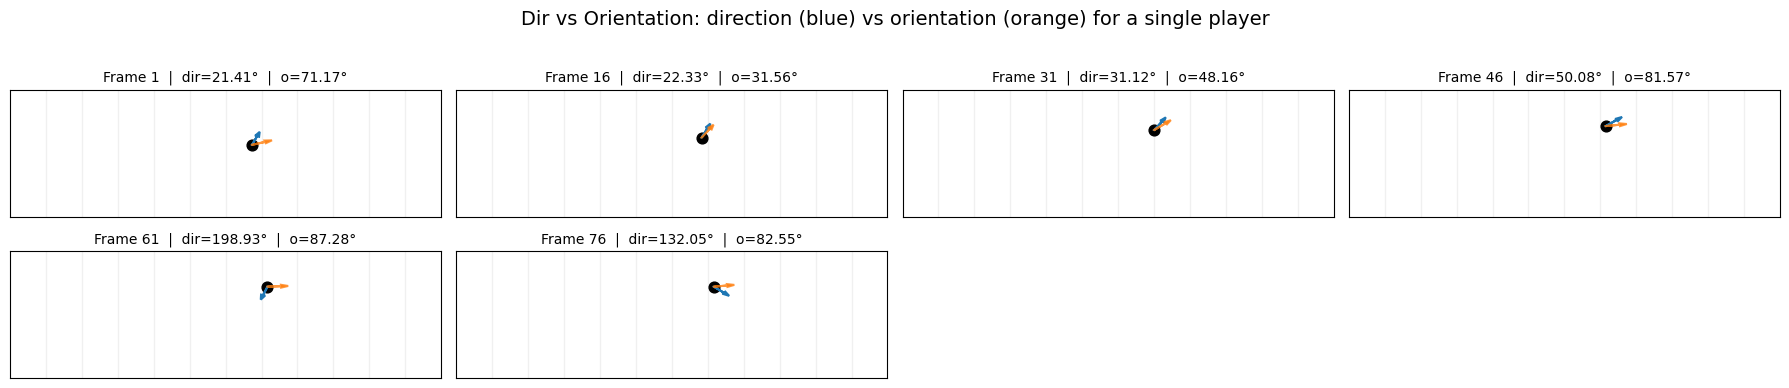

In [98]:
# df_player: rows for a single nflId on a single play
fig, axes = plot_dir_orientation_small_multiples(
    single_player,
    base_frame=int(single_player["frameId"].min()),
    offsets=(0, 15, 30, 45, 60, 75),
    arrow_len=5.0,
    scale_with_speed=True,
    show=True,
)

# Field Control Model Hyperparameters

Below are my default hyperparameters for this model. I am not going to use this notebook to really delve into different ways we can play with the configurations to achieve certain results, I will make a seperate notebook for that. This notebook will just take a default configuration for the model arguments and show you how they flow into the player influence model and the subsequent player and team level functions. I will make some brief notes on the section. The Grid component is how we divide the field into small subsections to capture the density within each small square on the field. My current resolution is 200x100 on a 120 yard field that is 53.3 yards wide to match NFL field dimensions. Orientation Bias is if you notice your direction needs to be altered from the pre-set data, but really this should be left at zero and not touched if your data is good.

The Gaussian component is controlled by the parameter gaussian_scale_factor, which scales the size of the elliptical Gaussian placed around the player. A larger value produces a more diffuse influence field, spreading the player’s local control farther out, while a smaller value keeps the influence tightly concentrated around the player’s dot. This term dominates at low speeds and represents the player’s immediate “space” on the field.

The Gamma component governs the forward-projected influence that emerges once a player begins moving. The parameter alpha_gamma sets the shape of the gamma distribution along the player’s heading: higher values produce a smoother, more bell-like forward density, while lower values produce a pointier, more triangular wedge. The forward reach of this gamma lobe is controlled by a dynamic rate parameter beta, which is clipped between beta_min and beta_max and modulated by the player’s speed. The parameter gamma_midpoint determines the speed (in yards per second) where this scaling is centered, effectively controlling how quickly forward reach ramps up as the player accelerates. The gamma_scale_factor acts as a multiplicative adjustment to expand or contract the entire gamma footprint. Beyond a specified cutoff distance (max_forward_distance), the forward mass is faded out, with the parameter forward_decay_factor controlling how gradual that fade is — larger values produce a longer-tailed influence, while smaller values force a quicker taper.

The angular cone filtering provides directional control on the forward projection. The gamma influence is soft-gated to a cone around the player’s heading, which ensures that the lobe points forward rather than spreading in all directions. The cone is wide at low speed and narrows as speed increases. Specifically, angle_limit_max sets the half-angle at very low speeds, angle_limit_min sets the half-angle at very high speeds, and angle_decay_factor controls how quickly the cone tightens as speed increases. Lower decay factors make the cone collapse more quickly with speed, producing a narrower wedge at moderate velocities.

Finally, the mixture weights determine how the Gaussian and Gamma components are blended as a function of speed. The Gaussian weight wG follows a logistic curve: at very low speed it approaches w_gaussian_max, meaning the influence is almost entirely Gaussian (round and symmetric), while at very high speed it approaches w_gaussian_min, meaning the influence is mostly Gamma (forward-oriented). The parameter gaussian_midpoint specifies the speed at which the two components contribute equally, and gaussian_steepness controls how sharply this transition happens. A higher steepness value makes the handoff between Gaussian and Gamma more abrupt, while a lower value produces a smoother blend.

In [99]:
# --------------------------------------------------------------------------- #
# Default Configuration for PlayerInfluenceModel
# --------------------------------------------------------------------------- #

model_kwargs: dict = dict(
    # ---------------- Grid resolution / field dimensions ---------------- #
    grid_x_res=200,      # number of points in X direction (field length)
    grid_y_res=100,      # number of points in Y direction (field width)
    field_x_max=120.0,   # field length in yards
    field_y_max=53.3,    # field width in yards

    # ---------------- Orientation bias ---------------------------------- #
    orientation_bias_deg=0.0,

    # ---------------- Gaussian component -------------------------------- #
    gaussian_scale_factor=0.7,
    # Scales the Gaussian ellipse size. Larger → more diffuse influence.

    # ---------------- Gamma component ----------------------------------- #
    alpha_gamma=11.0,
    # Shape parameter of gamma distribution; controls forward density shape.
    beta_min=1.0,
    beta_max=20.0,
    # Dynamic beta depends on speed; clipped between [beta_min, beta_max].
    gamma_midpoint=15.0,
    # Speed (yards/s) where beta ramp is centered; affects how reach scales.
    gamma_scale_factor=0.8,
    # Multiplicative shrink/expand factor for gamma influence footprint.
    max_forward_distance=20.0,
    # Cutoff distance (yards) beyond which gamma influence fades.
    forward_decay_factor=1.0,
    # Controls exponential decay after the forward cutoff. Higher = slower fade.

    # ---------------- Angular cone filtering ----------------------------- #
    angle_limit_min=15.0,
    # Cone half-angle (deg) at very high speed (narrow).
    angle_limit_max=45.0,
    # Cone half-angle (deg) at very low speed (wide).
    angle_decay_factor=2.0,
    # How fast cone narrows with speed. Lower = cone shrinks more quickly.

    # ---------------- Mixture weights (Gaussian vs Gamma) ---------------- #
    w_gaussian_min=0.2,
    # Minimum Gaussian weight (at very high speed).
    w_gaussian_max=1.0,
    # Maximum Gaussian weight (at near-zero speed).
    gaussian_midpoint=4.0,
    # Logistic midpoint: speed (yd/s) where weights are ~50/50.
    gaussian_steepness=2.0,
    # Logistic steepness: how sharply weights transition around midpoint.
)


# Model Usage

Below provides model usage. I call the model with my default arguments and isolate a single player and frame to compute. I then use the model to compute influence specifying he data set, frame, player and column names if you need to deviate from my current column structure. This will generate our density for the field and we can produce some statistics for the player's density to explore results.

In [102]:

model = PlayerInfluenceModel(**model_kwargs)

player_id = 40488.0
frame_id  = 150

single = model.compute_influence(
    df=df,
    frame_id=frame_id,
    player_ids=[player_id],
    id_col="nflId",
    name_col="displayName",
    x_col="x",
    y_col="y",
    speed_col="s",
    dir_col="dir",
    dist_from_ball_col="dist_from_football",
    density_out_col="density"      # put the 2D array here
)


if single.empty:
    raise ValueError("No rows returned; check frame_id/player_id.")
Z = single.iloc[0]["density"]


X, Y = model.grid.X, model.grid.Y
density_table = pd.DataFrame(Z, index=model.grid.y_vals, columns=model.grid.x_vals)


stats = pd.DataFrame({
    "frameId": [frame_id],
    "nflId": [player_id],
    "sum_density": [float(Z.sum())],
    "max_density": [float(Z.max())],
    "center_of_mass_x": [float((X * Z).sum() / (Z.sum() + 1e-9))],
    "center_of_mass_y": [float((Y * Z).sum() / (Z.sum() + 1e-9))],
})




In [103]:
stats

,frameId,nflId,sum_density,max_density,center_of_mass_x,center_of_mass_y
0,150,40488.0,160.304914,0.988973,95.40853,7.750177


We can also do this for a range of frames. Below is an example of how we might compute that

In [74]:
frames = range(120, 161, 1)
rows = []

for fid in frames:
    out = model.compute_influence(
        df=df,
        frame_id=fid,
        player_ids=[player_id],
        density_out_col="density",
    )
    if out.empty:
        continue
    r = out.iloc[0].copy()
    r["sum_density"] = float(r["density"].sum())
    rows.append(r)

player_frames = pd.DataFrame(rows)  # one row per frame for that player

# If you want a dict of density tables keyed by frame:
density_by_frame = {
    int(r.frameId): pd.DataFrame(r.density, index=model.grid.y_vals, columns=model.grid.x_vals)
    for _, r in player_frames.iterrows()
}


One thing we want to better understand is how speed effects our player density distribution. Our influence model varies based on a player's speed so to help set the appropriate parameters our diagnostic plot function below lets us set arbitrary speeds and plots them together to see the impact at low (1), medium (5) and high (10) speeds.

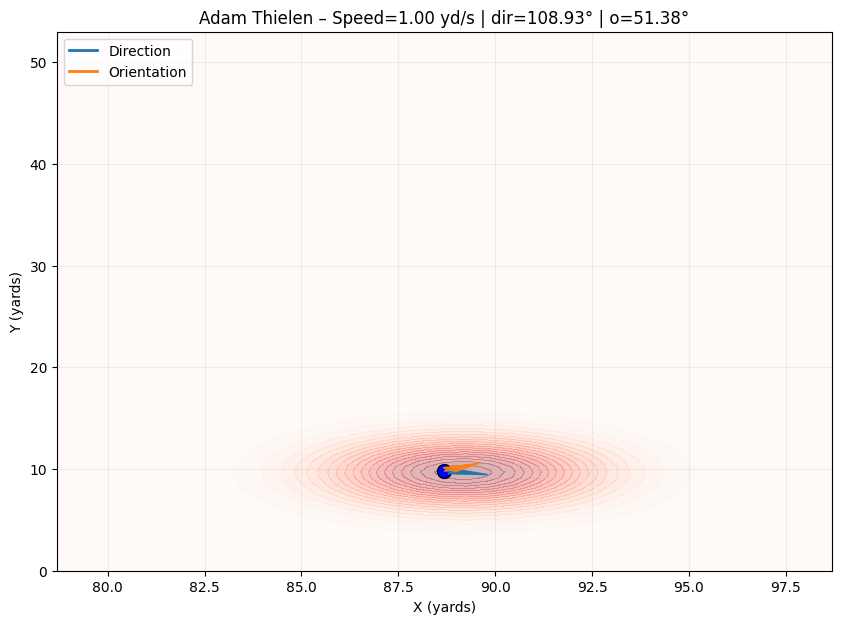

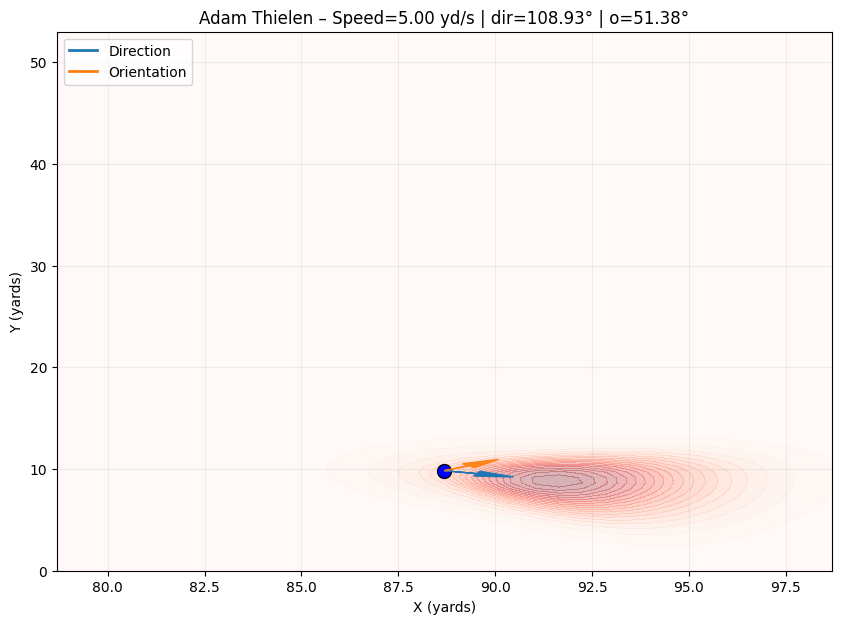

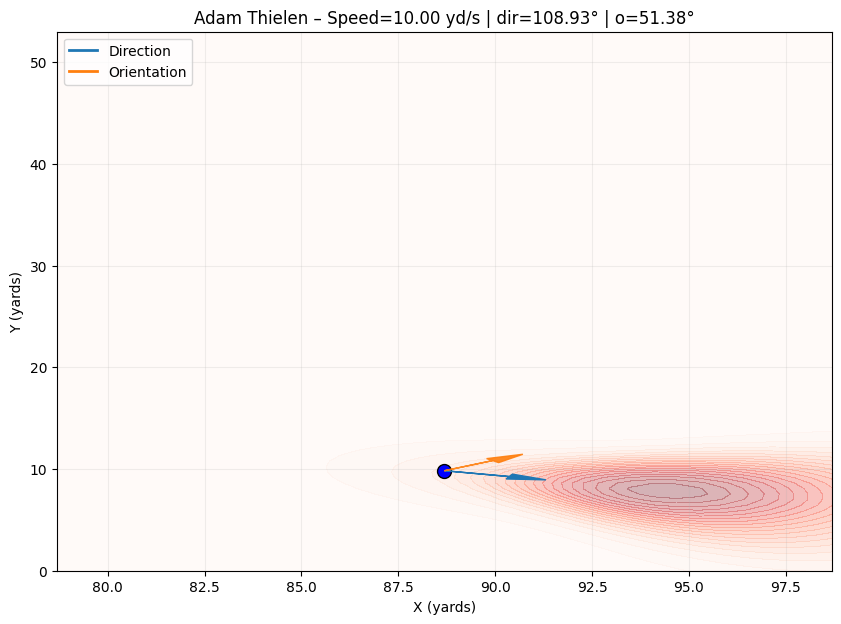

In [75]:

diagnostic_plot(df,
                frame_id=150,
                player_ids=[40488],
                speeds=(1,5,10),
                model_kwargs=model_kwargs,
                arrow_scale=2.0,
                arrow_head_width=0.5,
                arrow_head_length=1.0,)




There is also a small multiples version of this plot that is still in development, but can be used to plot multiple known frames with their known speeds instead of arbitary set speeds.

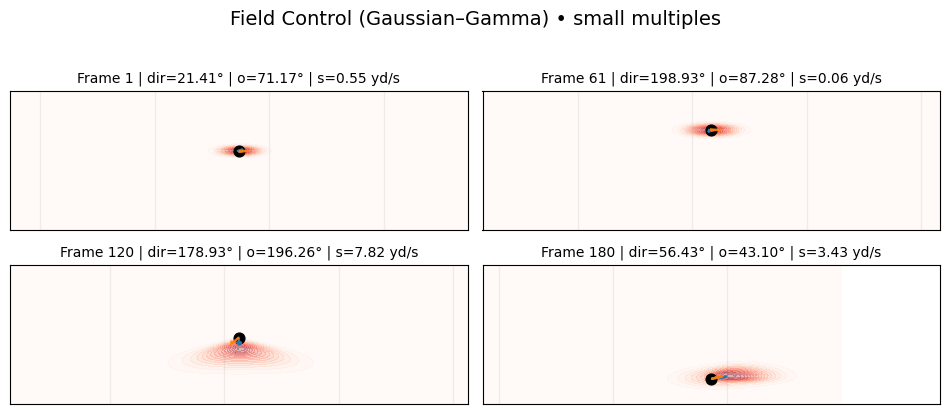

In [76]:


fig, axes, frames = plot_field_control_small_multiples(
    single_player,
    cols=2,
    n_panels=4,
    model_kwargs=model_kwargs,
    arrow_scale=2.5,          # smaller arrows
)


Another diagnostic plot you have at your disposal is the diagnostic multiples. This will take a set of model_kwargs and then tweak certain parameters around those arguments to give you an idea of what it would look if you increased or lowered the gaussian scale for example. This is also in development to give the user more power to tune, but it does print out the parameters for these different changes so you can potential plug those back into the model and continue to tune.

[Gaussian scale ↓] {'grid_x_res': 200, 'grid_y_res': 100, 'field_x_max': 120.0, 'field_y_max': 53.3, 'orientation_bias_deg': 0.0, 'gaussian_scale_factor': 0.48, 'alpha_gamma': 6.0, 'beta_min': 4.0, 'beta_max': 12.0, 'gamma_midpoint': 12.0, 'gamma_scale_factor': 0.9, 'max_forward_distance': 12.0, 'forward_decay_factor': 1.0, 'angle_limit_min': 20.0, 'angle_limit_max': 60.0, 'angle_decay_factor': 2.0, 'w_gaussian_min': 0.3, 'w_gaussian_max': 1.0, 'gaussian_midpoint': 3.0, 'gaussian_steepness': 1.5, 'speed': 10.0}
[Gaussian scale ↑] {'grid_x_res': 200, 'grid_y_res': 100, 'field_x_max': 120.0, 'field_y_max': 53.3, 'orientation_bias_deg': 0.0, 'gaussian_scale_factor': 1.1199999999999999, 'alpha_gamma': 6.0, 'beta_min': 4.0, 'beta_max': 12.0, 'gamma_midpoint': 12.0, 'gamma_scale_factor': 0.9, 'max_forward_distance': 12.0, 'forward_decay_factor': 1.0, 'angle_limit_min': 20.0, 'angle_limit_max': 60.0, 'angle_decay_factor': 2.0, 'w_gaussian_min': 0.3, 'w_gaussian_max': 1.0, 'gaussian_midpoint':

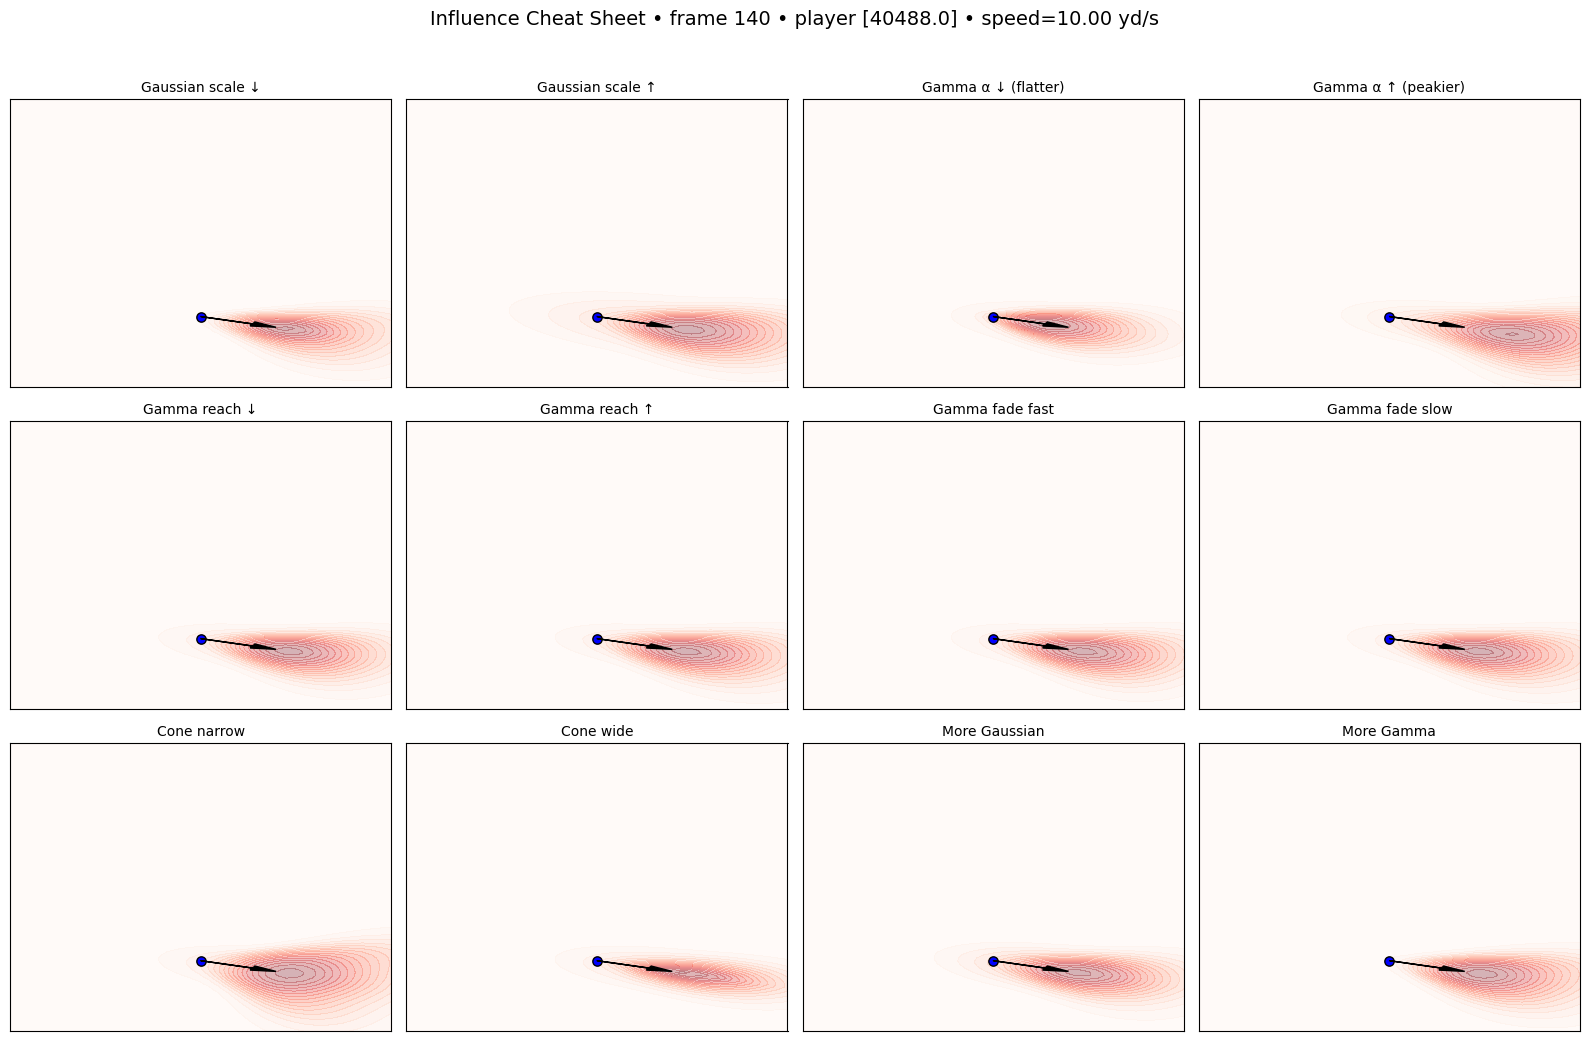

In [77]:


# 1) Run the cheat sheet — returns every panel’s params
fig, panels, params_df = diagnostic_multiples(
    df=df,
    frame_id=140,
    player_id=one_player,
    speed=10.0,
    model_kwargs=model_kwargs,
    verbose=True,   # prints the full dict for each panel
)





As an example, see below. We have function pick_panel_kwargs where you can identify the kwargs you want to use by name and then even change those if you'd like and save as a new set of arguments (mk) below.

In [78]:
# 2) Pick a panel’s params, tweak a couple, and build a model
mk = pick_panel_kwargs(panels, title="Gamma reach ↑", updates={"alpha_gamma": 12.0})
print(mk)
new_model = PlayerInfluenceModel(**mk)

{'grid_x_res': 200, 'grid_y_res': 100, 'field_x_max': 120.0, 'field_y_max': 53.3, 'orientation_bias_deg': 0.0, 'gaussian_scale_factor': 0.8, 'alpha_gamma': 12.0, 'beta_min': 4.0, 'beta_max': 12.0, 'gamma_midpoint': 12.0, 'gamma_scale_factor': 0.9, 'max_forward_distance': 16.799999999999997, 'forward_decay_factor': 1.0, 'angle_limit_min': 20.0, 'angle_limit_max': 60.0, 'angle_decay_factor': 2.0, 'w_gaussian_min': 0.3, 'w_gaussian_max': 1.0, 'gaussian_midpoint': 3.0, 'gaussian_steepness': 1.5}


You then feed that back into the diagnostic multiples and get a whole new set of plots based of your updated arguments and tweaking around those new parameters

[Gaussian scale ↓] {'grid_x_res': 200, 'grid_y_res': 100, 'field_x_max': 120.0, 'field_y_max': 53.3, 'orientation_bias_deg': 0.0, 'gaussian_scale_factor': 0.48, 'alpha_gamma': 12.0, 'beta_min': 4.0, 'beta_max': 12.0, 'gamma_midpoint': 12.0, 'gamma_scale_factor': 0.9, 'max_forward_distance': 16.799999999999997, 'forward_decay_factor': 1.0, 'angle_limit_min': 20.0, 'angle_limit_max': 60.0, 'angle_decay_factor': 2.0, 'w_gaussian_min': 0.3, 'w_gaussian_max': 1.0, 'gaussian_midpoint': 3.0, 'gaussian_steepness': 1.5, 'speed': 1.0}
[Gaussian scale ↑] {'grid_x_res': 200, 'grid_y_res': 100, 'field_x_max': 120.0, 'field_y_max': 53.3, 'orientation_bias_deg': 0.0, 'gaussian_scale_factor': 1.1199999999999999, 'alpha_gamma': 12.0, 'beta_min': 4.0, 'beta_max': 12.0, 'gamma_midpoint': 12.0, 'gamma_scale_factor': 0.9, 'max_forward_distance': 16.799999999999997, 'forward_decay_factor': 1.0, 'angle_limit_min': 20.0, 'angle_limit_max': 60.0, 'angle_decay_factor': 2.0, 'w_gaussian_min': 0.3, 'w_gaussian_ma

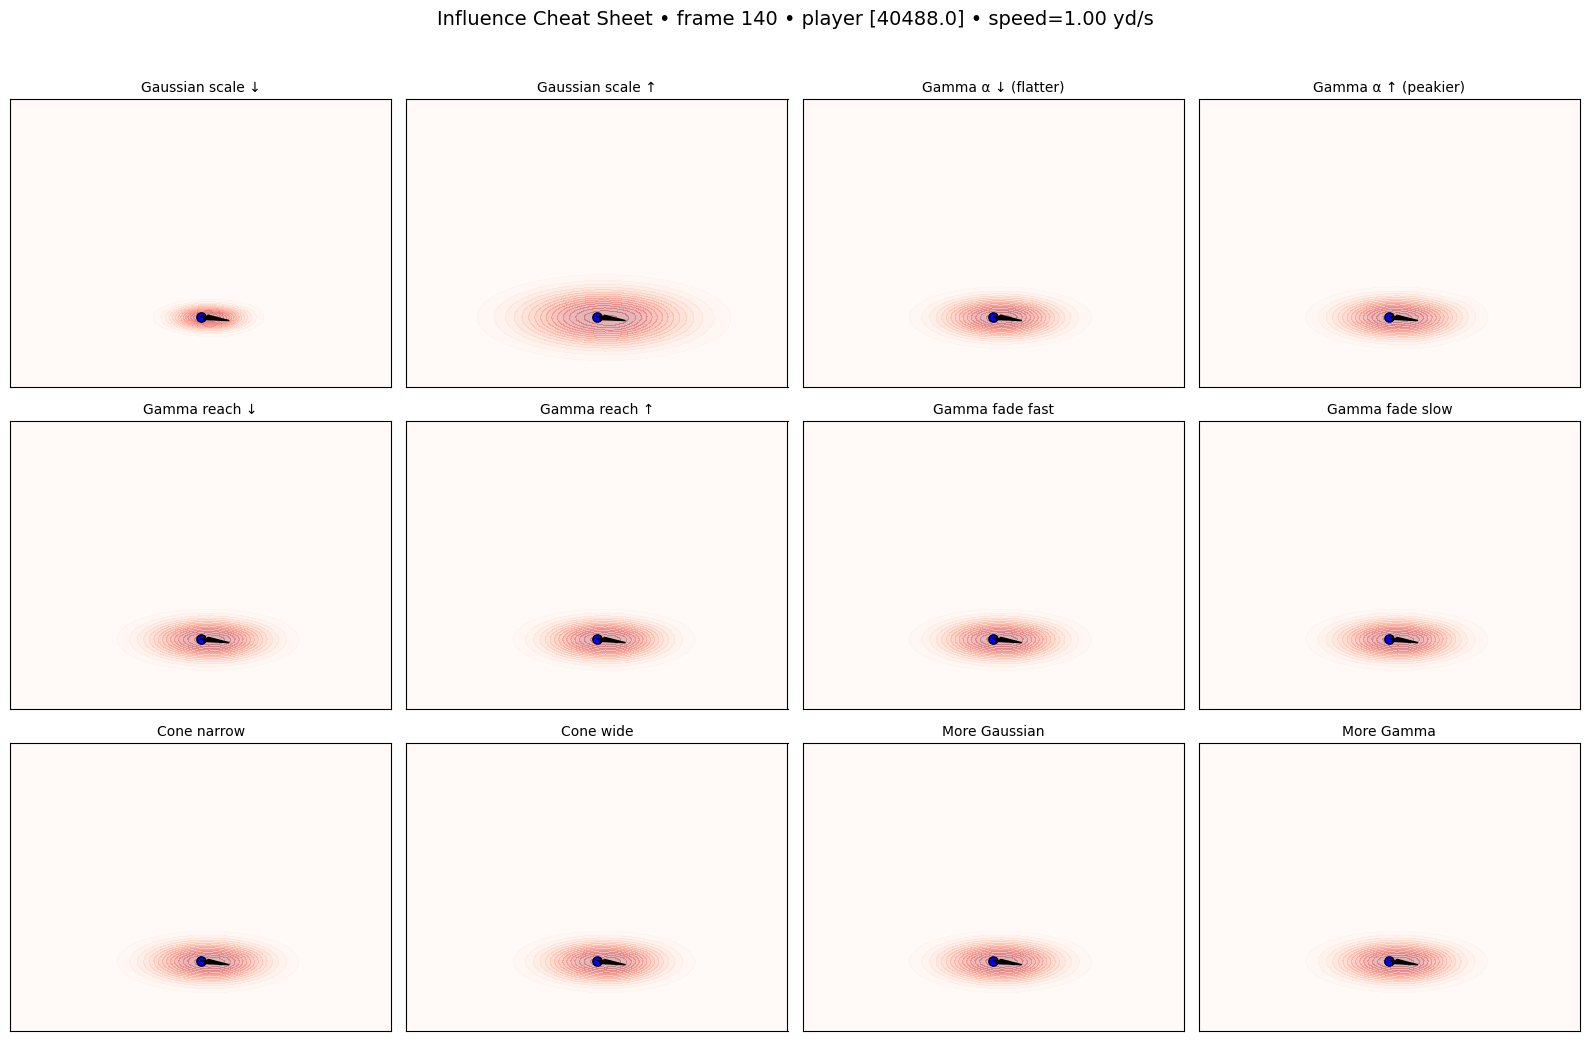

In [79]:


fig, panels, params_df = diagnostic_multiples(
    df=df,
    frame_id=140,
    player_id=one_player,
    speed=1.0,
    model_kwargs=mk,
    verbose=True,   # prints the full dict for each panel
)


# Computing Densities for Multiple Players.

We often don't wnat to compute the density for just a single player on a single frame. The function below allows us to generate densities for all players on multiple frames. Here we capture the densities for the entire.

In [80]:
# 1. Pick your frame range for the play
min_frame, max_frame = 1, max(df['frameId'])

# 2. Compute all player densities
all_player_df, (X, Y) = compute_player_densities_dataframe(
    df=df,
    min_frame=min_frame,
    max_frame=max_frame,
    model_kwargs=model_kwargs,
    exclude_football=True
)

# all_player_df now has one row per (frameId, nflId), with a "density" (2D np.array)
print(all_player_df.head())


   frameId    nflId     displayName  jerseyNumber      x          y  speed  \
0        1  38632.0    Kirk Cousins           8.0  68.13  31.343333   0.00   
1        1  40488.0    Adam Thielen          19.0  67.34  30.103333   0.55   
2        1  44834.0  Charles Harris          53.0  76.01  30.503333   0.00   
3        1  44888.0   Alex Anzalone          34.0  77.35  29.633333   0.01   
4        1  45094.0    Johnny Mundt          86.0  68.60  29.803333   1.40   

   direction  is_off  dist_from_football  theta_rad  orientation_bias_deg  \
0     206.72     1.0            6.201815   4.246037                   0.0   
1      21.41     1.0            6.730499   1.197121                   0.0   
2      78.90     0.0            2.227667   0.193732                   0.0   
3     107.30     0.0            3.314362   5.981243                   0.0   
4      32.31     1.0            5.450616   1.006880                   0.0   

                                             density  
0  [[0.0, 0.0

# Plotting the density for all players

Once the density is computed, you can plot the densities for a single frame for all players. We input the all_player_df we computed above, pass in our model grid and frame_id and then we can control contour levels and alpha as well as colors and arrow scale along with title. This shows us all the individual computed player densities for a singe play, but it does not give us field control at a team level, so densities can overlap one another.

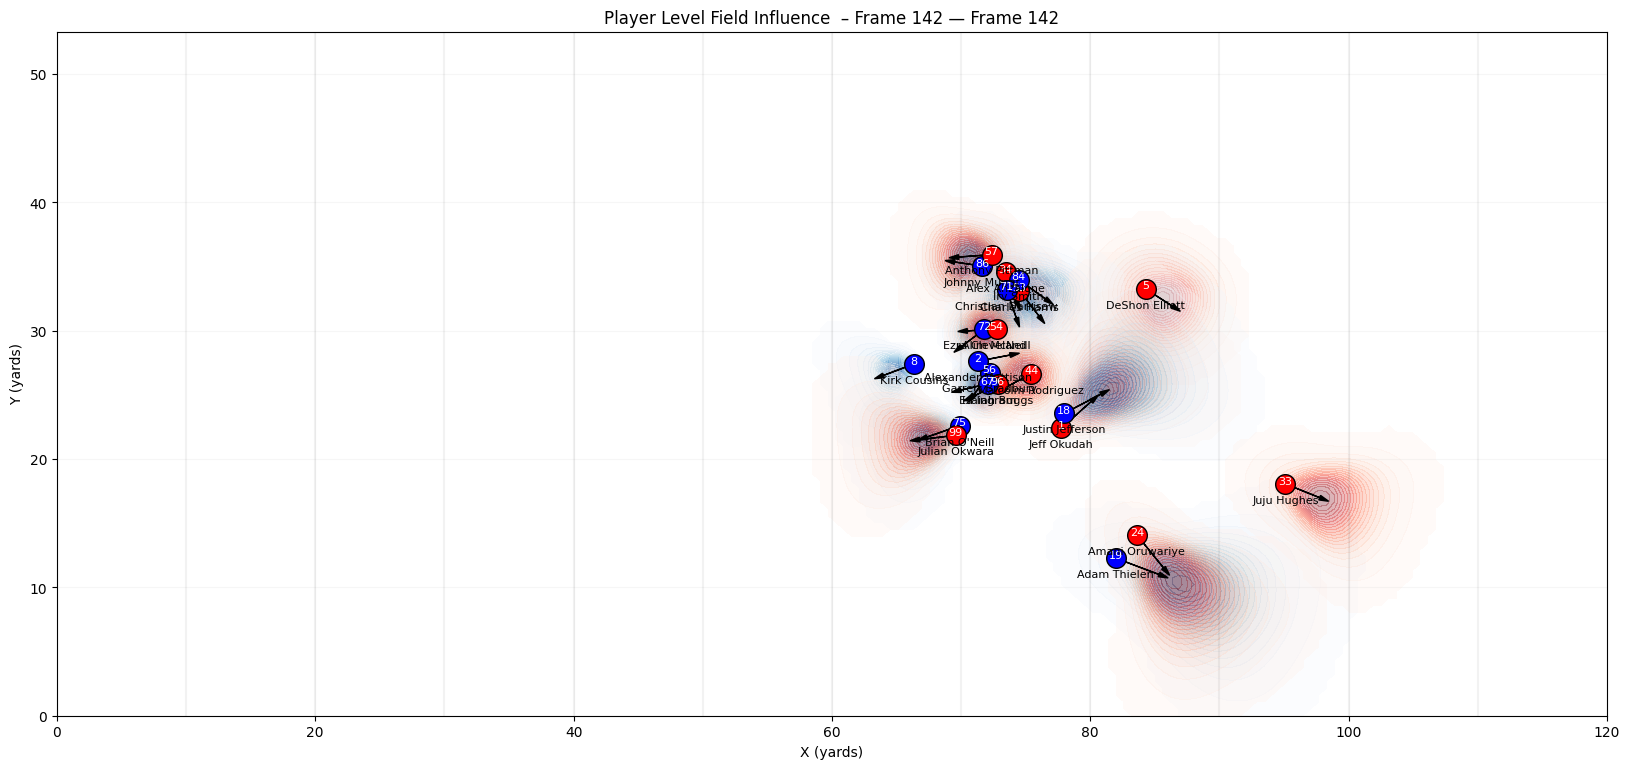

In [81]:

fig, ax = plot_player_densities_from_dataframe(
    all_player_df,
    grid=(X, Y),
    frame_id=142,
    contour_levels=20,
    contour_alpha=0.3,
    off_cmap="Reds",
    on_cmap="Blues",
    arrow_scale=2.0,
    title="Player Level Field Influence  – Frame 142"
)


I want to allow the user to plot multiple frames at once, but this function is still in development for small multiples of frames for a play.

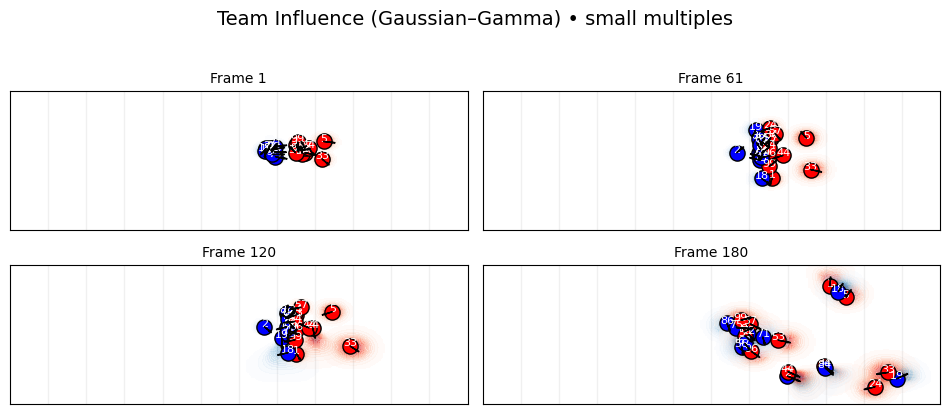

In [82]:
# 1) Zoom around the ball (per-frame)
fig, axes, used = plot_team_densities_small_multiples(
    all_player_df, (X, Y),
    n_panels=4, cols=2,
    zoom_mode="ball", zoom_width=40.0, zoom_height=40.0,
)




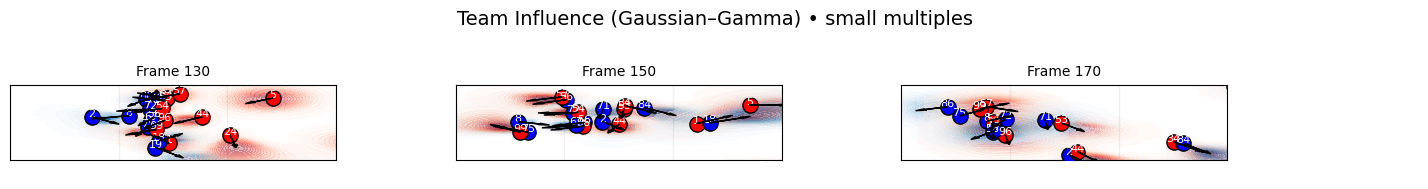

In [83]:
# 2) Zoom around LOS; constant x=75 (e.g., set by your play metadata)
fig, axes, used = plot_team_densities_small_multiples(
    all_player_df, (X, Y),
    frames=[130,150,170,190,210,230],
    zoom_mode="los", los_x=75.0, zoom_width=30.0, zoom_height=26.0,
)



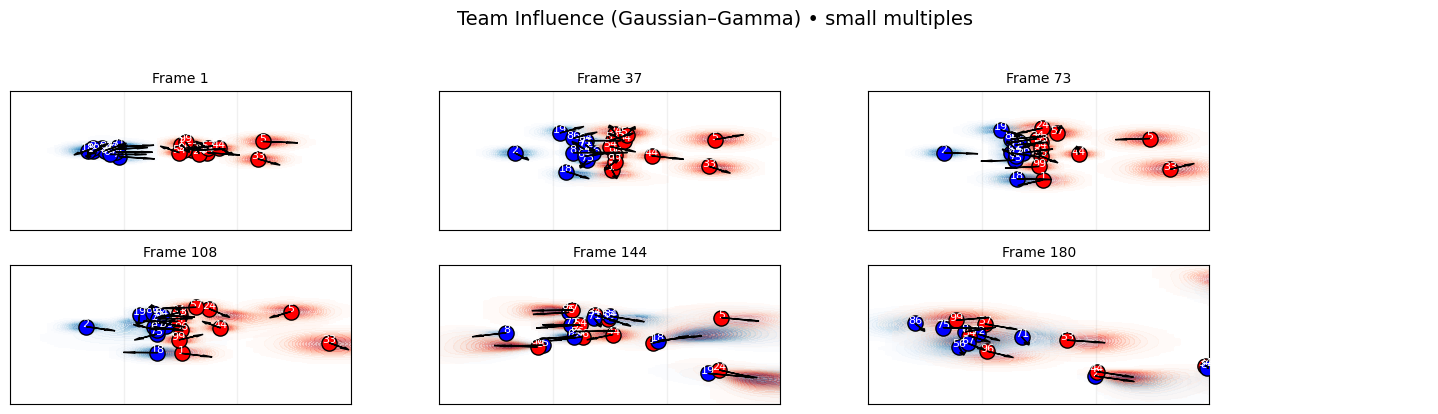

In [84]:
# 3) Zoom using per-frame LOS column (if present on player_df)
fig, axes, used = plot_team_densities_small_multiples(
    all_player_df.assign(los_x=75.0), (X, Y),
    n_panels=6, cols=3, zoom_mode="los",
)



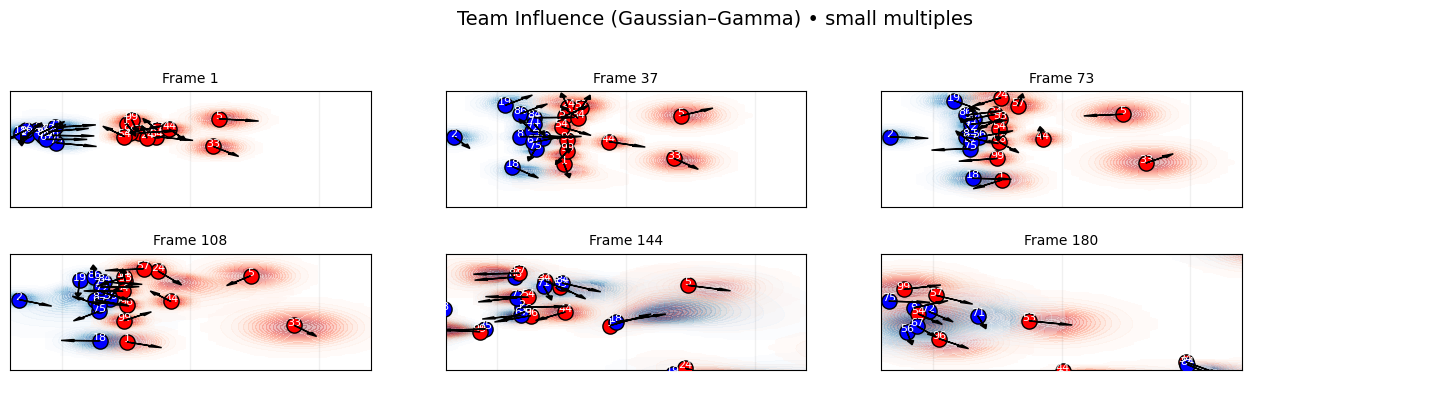

In [85]:
# 4) Fixed center (x,y)
fig, axes, used = plot_team_densities_small_multiples(
    all_player_df, (X, Y),
    zoom_mode="fixed", fixed_center=(80.0, 26.65), zoom_width=28.0, zoom_height=28.0,
)

# Animate the Play

Finally, There is a class that allow you to animate the play below. Please allow a couple minutes to create the animation, which should download. If you are using a IDE that allows for in-line visualiztion, It may be worth visualizing as opposed to downloading

In [86]:

anim = AnimatePlayWithDensity(df, all_player_df, grid=(X, Y), show_contours=True)
anim.ani.save("play_influence.mp4", fps=10, dpi=150)


# Team Level Field Control

This section will go over the functionality to compute team level field control. We will no longer be defining an area of control as owned by a single player in which densities can overlap and there is no true space ownership, but instead individual densities displayed to show the effects of our choices at a player level. These next functions will translate that into offensive and defensive control. The function below computes player densities for team level field control which is mutually exclusive. This means a part of the field is either owned by defense, offense or not owned because it is either around a 50/50 split or no player is close enough to own that space. This returns data frames for offense, defense, and pitch control by frame.

In [87]:
players_all, off_by_f, def_by_f, pc_by_f, (X, Y), frames_used = compute_player_densities_team_control(
    model=PlayerInfluenceModel(),
    df=df,
    frame_id=150,
    use_cached_density=False,
    force_recompute=True,
    heading_col="dir",
)

player_df   = players_all[players_all["frameId"] == 150]
off_df      = off_by_f[150]
def_df      = def_by_f[150]
pc_df       = pc_by_f[150]


We can now visualize this for a single frame. Red indicates defensive ownership, blue indicates offensive ownership and white is space no one currently owns on this frame

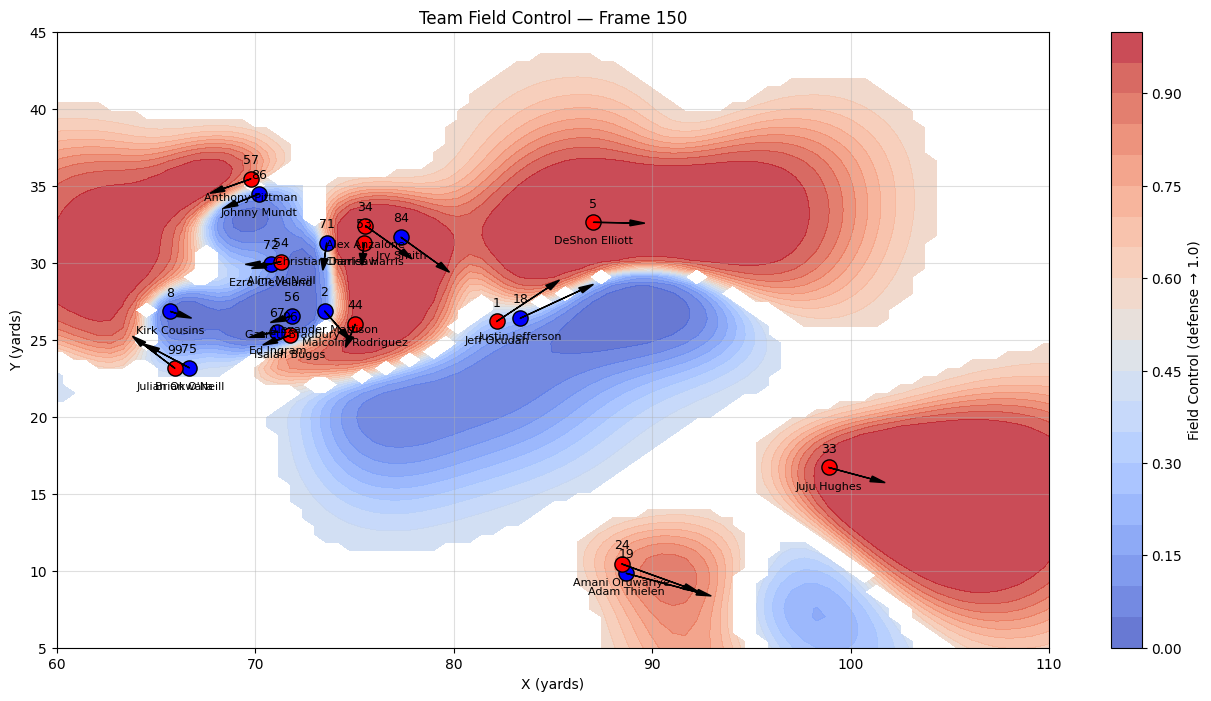

(<Figure size 1600x800 with 2 Axes>,
 <Axes: title={'center': 'Team Field Control — Frame 150'}, xlabel='X (yards)', ylabel='Y (yards)'>)

In [88]:
visualize_team_control(
    pc_df, player_df=player_df, frame_id=117,
    heading_col="dir", invert_heading=False
)

The function below does this process for multiple frames and then animates it so we can have a gif of the play. I've created two functions for the animation since the first, while better resolution, is slow to produce. the fast animation is for quicker alteration.

In [89]:


players_all, off_by_f, def_by_f, pc_by_f, (X, Y), frames_used = compute_player_densities_team_control(
    model=PlayerInfluenceModel(),
    df=df,
    min_frame=1, max_frame=max(df['frameId'])
)


In [90]:
ani = animate_pitch_control_with_players(
    player_df=players_all,
    pc_by_frame=pc_by_f,
    frames=frames_used,
    heading_col="direction",
    arrow_scale=5.0,
    xlim=(60,110), ylim=(5,45),
)


ani.save("team_field_control.mp4", fps=10, dpi=100)

In [91]:
ani = animate_pitch_control_with_players_fast(
    player_df=players_all,
    pc_by_frame=pc_by_f,
    frames=sorted(pc_by_f.keys()),
    heading_col="direction",
    arrow_len=1.5,
    shaft_width_ax=0.003,
    head_length_pt=2.0,
    head_width_pt=1.5
)


ani.save("field_control_fast.mp4", fps=12, dpi=130, writer="ffmpeg")


I hope you found this example usage useful. This package will be in continual development so come back as functionality gets added and current functions are improved